<a href="https://colab.research.google.com/github/Ripa-Shah/Analyzing-Social-Sentiment-Data-to-determine-correlation-with-Cryptocurrency-Price/blob/main/MIS584_Cryptocurrency_sentimentdata_and_prices_11_18_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [186]:
pip install pyspark praw nltk pandas

In [187]:
%pwd

'/content/drive/MyDrive/ColabNotebooks/Data'

In [188]:
pip install tweepy praw requests pandas textblob vaderSentiment

In [189]:
pip install vaderSentiment

In [190]:
import praw
import pandas as pd
import time
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## #I'll be implementing this project with reddit historical dataset using reddit API and pricing data using yahoo finance. Currently, I'm mounting the dataset with Google drive.

In [191]:
from google.colab import drive
drive.mount('/content/drive')
DATA_FOLDER_PATH = '/content/drive/MyDrive/ColabNotebooks/Data'

# Example: List the contents of your data folder
import os
print(os.listdir(DATA_FOLDER_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['mis584_float.txt', 'converted_file2.txt', 'transformed_numbers.txt', 'stock_schema.avsc', 'wikidata.csv', '.ipynb_checkpoints', 'crypto_prices.csv', 'reddit_crypto_sentiment_analysis.csv']


In [192]:
%cd /content/drive/MyDrive/ColabNotebooks/Data

/content/drive/MyDrive/ColabNotebooks/Data


In [193]:
%pwd

'/content/drive/MyDrive/ColabNotebooks/Data'

Cryptocurrency prices will retrieve from yahoo finance so I'm installing yahoo finance library.

In [194]:
pip install yfinance pandas

# This entire project will be in pyspark so I'm downloading and installing pyspark library.

In [195]:
!pip install pyspark

In [198]:
sc.stop()

## I'm setting up the configuration and spark session

In [199]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("MIS584_Spark_Basics")
sc = SparkContext(conf = conf)

In [200]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MIS584_Spark_Basics").getOrCreate()

In [201]:

# you can get a spark context from a spark session
sc = spark.sparkContext

In [ ]:
#download the dataset crypto_prices_historical.csv and reddit_crypto_Sentiment.csv

# I've converted this csv file into pandas data frame.

In [202]:
# create a spark dataframe from a pandas dataframe
import pandas as pd

## first, read the external csv file into a pandas dataframe
crypto_prices = pd.read_csv('crypto_prices.csv')

## then, convert the pandas dataframe to a spark dataframe
df_crypto_prices = spark.createDataFrame(crypto_prices)
df_crypto_prices.show(n=10)

## we can also convert a spark dataframe to a pandas dataframe
pdf_crypto_prices = df_crypto_prices.toPandas()
print(pdf_crypto_prices.head(20))

+-------------------+-------+--------------+
|          timestamp| symbol|         price|
+-------------------+-------+--------------+
|2025-06-15 00:00:00|BTC-USD|105531.8359375|
|2025-06-15 04:00:00|BTC-USD|    105487.625|
|2025-06-15 08:00:00|BTC-USD|104985.6171875|
|2025-06-15 12:00:00|BTC-USD|105582.1953125|
|2025-06-15 16:00:00|BTC-USD|105300.0078125|
|2025-06-15 20:00:00|BTC-USD|105552.8671875|
|2025-06-16 00:00:00|BTC-USD|105940.2109375|
|2025-06-16 04:00:00|BTC-USD|     107042.75|
|2025-06-16 08:00:00|BTC-USD| 106875.265625|
|2025-06-16 12:00:00|BTC-USD|  107417.15625|
+-------------------+-------+--------------+
only showing top 10 rows

              timestamp   symbol          price
0   2025-06-15 00:00:00  BTC-USD  105531.835938
1   2025-06-15 04:00:00  BTC-USD  105487.625000
2   2025-06-15 08:00:00  BTC-USD  104985.617188
3   2025-06-15 12:00:00  BTC-USD  105582.195312
4   2025-06-15 16:00:00  BTC-USD  105300.007812
5   2025-06-15 20:00:00  BTC-USD  105552.867188
6   2025

# I'm converting pricing dataset into spark data frame.:

In [203]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
# Import any other types you need (StringType, IntegerType, etc.)
# create a spark dataframe from a csv file with inferred schema:
# df_reddit_crypto_price = spark.read.csv('crypto_prices.csv', header=True, inferSchema=True) # Spark will automatically detect the data type of each column.
# df_reddit_crypto_price.show()

# print the schema (column names and types of a dataframe)
# print('Inferred Schema of the DataFrame:')
# df_reddit_crypto_price.printSchema()

# create a spark dataframe from a csv file with specified schema:
schema = StructType([
    StructField('timestamp', StringType(), True),
    StructField('symbol', StringType(), True),
    StructField('price',DoubleType(),True)
])
df_reddit_crypto_price = spark.read.csv('crypto_prices.csv', header=True, schema=schema)
print('Specified Schema of the DataFrame:')
df_reddit_crypto_price.printSchema()

#rename column timestamp to date
df_reddit_crypto_price = df_reddit_crypto_price.withColumnRenamed("timestamp", "date")

# Display the new schema to confirm the change
df_reddit_crypto_price.printSchema()


Specified Schema of the DataFrame:
root
 |-- timestamp: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- price: double (nullable = true)

root
 |-- date: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- price: double (nullable = true)



# Here I'm renaming timestamp field as timestamp field

In [204]:
df_reddit_price_renamed = df_reddit_crypto_price.withColumnRenamed("timestamp", "date")

In [205]:
# create a spark dataframe from a pandas dataframe
import pandas as pd

## first, read the external csv file into a pandas dataframe
df_reddit_crypto_sentiment = pd.read_csv('reddit_crypto_sentiment_analysis.csv')

## then, convert the pandas dataframe to a spark dataframe
df_reddit_crypto_sentiment = spark.createDataFrame(pdf_crypto_prices)
df_reddit_crypto_sentiment.show(n=5)

## we can also convert a spark dataframe to a pandas dataframe
pdf_reddit_sentiment = df_reddit_crypto_sentiment.toPandas()
print(pdf_reddit_sentiment.head(20))

+-------------------+-------+--------------+
|          timestamp| symbol|         price|
+-------------------+-------+--------------+
|2025-06-15 00:00:00|BTC-USD|105531.8359375|
|2025-06-15 04:00:00|BTC-USD|    105487.625|
|2025-06-15 08:00:00|BTC-USD|104985.6171875|
|2025-06-15 12:00:00|BTC-USD|105582.1953125|
|2025-06-15 16:00:00|BTC-USD|105300.0078125|
+-------------------+-------+--------------+
only showing top 5 rows

              timestamp   symbol          price
0   2025-06-15 00:00:00  BTC-USD  105531.835938
1   2025-06-15 04:00:00  BTC-USD  105487.625000
2   2025-06-15 08:00:00  BTC-USD  104985.617188
3   2025-06-15 12:00:00  BTC-USD  105582.195312
4   2025-06-15 16:00:00  BTC-USD  105300.007812
5   2025-06-15 20:00:00  BTC-USD  105552.867188
6   2025-06-16 00:00:00  BTC-USD  105940.210938
7   2025-06-16 04:00:00  BTC-USD  107042.750000
8   2025-06-16 08:00:00  BTC-USD  106875.265625
9   2025-06-16 12:00:00  BTC-USD  107417.156250
10  2025-06-16 16:00:00  BTC-USD  108497.3

##Similarly, I'm converting reddit crypto sentiment analysis file to pyspark.

In [206]:
from pyspark.sql.types import *

# create a spark dataframe from a csv file with inferred schema:
df_reddit_crypto = spark.read.csv('reddit_crypto_sentiment_analysis.csv', header=True, inferSchema=True) # Spark will automatically detect the data type of each column.
df_reddit_crypto.show()

# print the schema (column names and types of a dataframe)
print('Inferred Schema of the DataFrame:')
df_reddit_crypto.printSchema()

# create a spark dataframe from a csv file with specified schema:
schema = StructType([
    StructField('date', TimestampType(), True),
    StructField('user_id', StringType(), True),
    StructField('tyoe', StringType(), True),
    StructField('title', StringType(), True),
    StructField('cryptocurrency', StringType(), True),
    StructField('review',StringType(),True),
    StructField('sentiment_score',DoubleType(),True)
])
df_reddit_crypto = spark.read.csv('reddit_crypto_sentiment_analysis.csv', header=True, schema=schema)
print('Specified Schema of the DataFrame:')
df_reddit_crypto.printSchema()

+--------------------+--------------------+-------+-----------------------------------------+----+--------------------+--------------------+
| 2025-11-18 12:00:00|      Odd-Radio-8500|   post|People with 0,05 BTC looking at nocoiners| BTC|                 _c5|                 0.0|
+--------------------+--------------------+-------+-----------------------------------------+----+--------------------+--------------------+
| 2025-11-18 12:00:00|         Real_SkrexX|comment|                     People with 0,05 ...| BTC|          That's me!|                 0.0|
| 2025-11-18 12:00:00|  Next_Statement6145|comment|                     People with 0,05 ...| BTC|0.005 BTC and i f...|                 0.0|
| 2025-11-18 12:00:00|   ClitYeastWood1337|comment|                     People with 0,05 ...| BTC|Just learned a ne...|                 0.0|
| 2025-11-18 12:00:00|    Ikki_The_Phoenix|comment|                     People with 0,05 ...| BTC|Dude. I wish BTC ...|              0.4019|
| 2025-11-18 

Let's analyze the data using pyspark. First of all, I'm focusing on general analyzing. Here, I'm counting number of rows in the data frame. Additionally, I'm also checking howmany columns this dataset have.

In [207]:
# get the number of rows for a dataframe
print()
print('Number of rows of the DataFrame:', df_reddit_crypto.count())

# get the number of columns and column ames for a dataframe
print()
print('Number of columns of the DataFrame:', len(df_reddit_crypto.columns))
print('Column names of the DataFrame:', df_reddit_crypto.columns)


Number of rows of the DataFrame: 3386

Number of columns of the DataFrame: 7
Column names of the DataFrame: ['date', 'user_id', 'tyoe', 'title', 'cryptocurrency', 'review', 'sentiment_score']


Once I've number of rows ready. I'm stepping towards data cleaning. I'm dropping duplicates from the reddit sentiment dataset.

In [208]:
# drop duplicates from a reddit sentiment dataframe
print('Number of rows before dropping duplicates:', df_reddit_crypto.count())
df_reddit_crypto.dropDuplicates().count()
print('Number of rows after dropping duplicates:', df_reddit_crypto.dropDuplicates().count())

Number of rows before dropping duplicates: 3386
Number of rows after dropping duplicates: 2679


Similarly, I'm dropping duplicates from pricing dataset.

In [209]:
#drop duplicates from yahoo finance prices dataset

print('Number of rows before dropping duplicates:', df_reddit_price_renamed.count())
df_yahoo_price_unique = df_reddit_price_renamed.dropDuplicates()
print('Number of rows after removing duplicates:',df_yahoo_price_unique.count())

Number of rows before dropping duplicates: 4660
Number of rows after removing duplicates: 4660


For yahoo finance and reddit sentiment, I'm analyzing columns.[link text](https://)

In [210]:
#print statistics of data frame

df_yahoo_price_unique.describe()

DataFrame[summary: string, date: string, symbol: string, price: string]

In [211]:
#print statistics of data frame
df_reddit_crypto.describe()



DataFrame[summary: string, user_id: string, tyoe: string, title: string, cryptocurrency: string, review: string, sentiment_score: string]

It seems like I've done some typo while converting dataset into pyspark. To correct this, I'm renaming the field in pyspark.

In [212]:
#rename column tyoe to type

df_reddit_crypto = df_reddit_crypto.withColumnRenamed("tyoe", "type")

# Display the new schema to confirm the change
df_reddit_crypto.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- user_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- cryptocurrency: string (nullable = true)
 |-- review: string (nullable = true)
 |-- sentiment_score: double (nullable = true)



In [213]:
from pyspark.sql.functions import current_timestamp, to_timestamp


Furthermore, I'm filling the values missing for the text dataset. I'm implementing mean imputation for sentiment_score

In [214]:

#fill missing values with keyword missing and for sentiment_score ->0.0

from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["sentiment_score"],
                  outputCols=["sentiment_score_imputed"]) \
                  .setStrategy("mean")

model = imputer.fit(df_reddit_crypto)
df_reddit_crypto_filled = model.transform(df_reddit_crypto)

# Show the result
df_reddit_crypto_filled.show(n=100)
#df_reddit_crypto_filled = df_reddit_crypto.na.fill(value=0.0, subset=['sentiment_score'])
#df_reddit_crypto.na.fill(current_timestamp(), subset=["date"])
df_reddit_crypto_missing = df_reddit_crypto_filled.na.fill(value='missing', subset=['cryptocurrency','title','review','user_id','type'])
#df_reddit_crypto.na.fill(value='1/1/1930', subset=['date']).show(100)

+-------------------+--------------------+--------------------+--------------------+--------------+--------------------+---------------+-----------------------+
|               date|             user_id|                type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|
+-------------------+--------------------+--------------------+--------------------+--------------+--------------------+---------------+-----------------------+
|2025-11-18 12:00:00|         Real_SkrexX|             comment|People with 0,05 ...|           BTC|          That's me!|            0.0|                    0.0|
|2025-11-18 12:00:00|  Next_Statement6145|             comment|People with 0,05 ...|           BTC|0.005 BTC and i f...|            0.0|                    0.0|
|2025-11-18 12:00:00|   ClitYeastWood1337|             comment|People with 0,05 ...|           BTC|Just learned a ne...|            0.0|                    0.0|
|2025-11-18 12:00:00|    Ikki_The_

In [215]:
df_reddit_crypto_missing.show(5)

+-------------------+------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|               date|           user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|
+-------------------+------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|2025-11-18 12:00:00|       Real_SkrexX|comment|People with 0,05 ...|           BTC|          That's me!|            0.0|                    0.0|
|2025-11-18 12:00:00|Next_Statement6145|comment|People with 0,05 ...|           BTC|0.005 BTC and i f...|            0.0|                    0.0|
|2025-11-18 12:00:00| ClitYeastWood1337|comment|People with 0,05 ...|           BTC|Just learned a ne...|            0.0|                    0.0|
|2025-11-18 12:00:00|  Ikki_The_Phoenix|comment|People with 0,05 ...|           BTC|Dude. I wish BTC ...|         0.4019|   

We will be using date field to join the pricing and reddit sentiment dataset. It is imperative to remove nulls from the date field.

In [216]:
print("Total number of rows before removing null values from date field")
df_reddit_crypto_missing.count()
df_reddit_crypto_cleaned = df_reddit_crypto_missing.dropna(subset=['date'])
print("Total number of rows after removing null values from date field")
df_reddit_crypto_cleaned.count()

Total number of rows before removing null values from date field
Total number of rows after removing null values from date field


1949

I've already clean data now. However, I also would like to check whether cryptocurrency field has a garbage values or not. I found plenty of garbage values.

In [217]:
from pyspark.sql.functions import col, when
# List of values to EXCLUDE
excluded_cryptos = ["BTC", "ETH", "SOL", "ADA","DOGE","missing"]  # Adjusted BTH to BTC for clarity

# Find rows where the cryptocurrency IS NOT in the excluded list
df_other_cryptos = df_reddit_crypto_cleaned.filter(~col("cryptocurrency").isin(excluded_cryptos)
)

df_reddit_main_cryptos = df_reddit_crypto_cleaned.filter(col("cryptocurrency").isin(excluded_cryptos))
print("--Main cryptos")
df_reddit_main_cryptos.show()
df_reddit_main_cryptos_count = df_reddit_main_cryptos.count()
print("--Main cryptos to count:",{df_reddit_main_cryptos_count})


# Display the result
print("--- Rows where cryptocurrency IS NOT BTC, ETH, SOL, or ADA ---")
df_other_cryptos.show()

# count the result
df_other_cryptos_count = df_other_cryptos.count()
print("Total excluded count",{df_other_cryptos_count})

# Show the distinct names of the excluded cryptocurrencies
#df_to_save = df_other_cryptos.select("cryptocurrency").distinct()

# Assuming 'df_to_save' is the DataFrame you want to export (e.g., df_other_cryptos)

#CSV_FILE_EXCLUDE= 'exclude_cryptocurrency.csv'
#df_to_save.write.csv(
 #   CSV_FILE_EXCLUDE,
 #   mode="overwrite",      # Options: 'overwrite', 'append', 'ignore', 'error' (default)
 #   header=True            # Writes the column names as the first line of the file
#)


--Main cryptos
+-------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|               date|             user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|
+-------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|2025-11-18 12:00:00|         Real_SkrexX|comment|People with 0,05 ...|           BTC|          That's me!|            0.0|                    0.0|
|2025-11-18 12:00:00|  Next_Statement6145|comment|People with 0,05 ...|           BTC|0.005 BTC and i f...|            0.0|                    0.0|
|2025-11-18 12:00:00|   ClitYeastWood1337|comment|People with 0,05 ...|           BTC|Just learned a ne...|            0.0|                    0.0|
|2025-11-18 12:00:00|    Ikki_The_Phoenix|comment|People with 0,05 ...|           BTC|Dude. I wis

Now, I'm filtering positive, negative and neutral sentiment. Thus, I'm filtering the dataframe to check whether this sentiment is positive, negative and neutral.

In [218]:

# apply the filter transformation on a dataframe
print('Reddit posts and comments positive sentiment score:')
df_reddit_main_cryptos.filter(df_reddit_main_cryptos['sentiment_score_imputed'] > 0.0)
df_reddit_main_cryptos.show(n=5)
print('Reddit posts and comments negative sentiment score:')
df_reddit_main_cryptos.filter(df_reddit_main_cryptos['sentiment_score_imputed'] < 0.0)
df_reddit_main_cryptos.show(n=5)
print('Reddit posts and comments neutral sentiment score:')
df_reddit_main_cryptos.filter(df_reddit_main_cryptos['sentiment_score_imputed'] == 0.0)
df_reddit_main_cryptos.show(n=5)



Reddit posts and comments positive sentiment score:
+-------------------+------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|               date|           user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|
+-------------------+------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+
|2025-11-18 12:00:00|       Real_SkrexX|comment|People with 0,05 ...|           BTC|          That's me!|            0.0|                    0.0|
|2025-11-18 12:00:00|Next_Statement6145|comment|People with 0,05 ...|           BTC|0.005 BTC and i f...|            0.0|                    0.0|
|2025-11-18 12:00:00| ClitYeastWood1337|comment|People with 0,05 ...|           BTC|Just learned a ne...|            0.0|                    0.0|
|2025-11-18 12:00:00|  Ikki_The_Phoenix|comment|People with 0,05 ...|   

I've sentiment_score column. I'm adding sentiment_labeel column using pyspark withColumn functionality

In [219]:
#Add additional column called sentiment_label
from pyspark.sql.functions import col, when
POSITIVE_THRESHOLD = 0.1
NEGATIVE_THRESHOLD = -0.1

df_reddit_main_cryptos = df_reddit_main_cryptos.withColumn(
    "sentiment_label",
    when(col("sentiment_score_imputed") > POSITIVE_THRESHOLD, "Positive")
    .when(col("sentiment_score_imputed") < NEGATIVE_THRESHOLD, "Negative")
    .otherwise("Neutral")
)
df_reddit_main_cryptos.show(n=10)


+-------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+---------------+
|               date|             user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|sentiment_label|
+-------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+---------------+
|2025-11-18 12:00:00|         Real_SkrexX|comment|People with 0,05 ...|           BTC|          That's me!|            0.0|                    0.0|        Neutral|
|2025-11-18 12:00:00|  Next_Statement6145|comment|People with 0,05 ...|           BTC|0.005 BTC and i f...|            0.0|                    0.0|        Neutral|
|2025-11-18 12:00:00|   ClitYeastWood1337|comment|People with 0,05 ...|           BTC|Just learned a ne...|            0.0|                    0.0|        Neutral|
|2025-11-18 12:0

Additionally, I'm implementing groupby clause to group a dataframe by certain columns and calculating a group statistics. Here, I'm counting total number of reviews and total number of titles for userids.

In [220]:
# group a dataframe by certain columns and calculate group statistics
from pyspark.sql.functions import max, min, sum, avg, stddev, round, count

print('Top total number of posts and comments posted by a userid:')
df_reddit_count = df_reddit_main_cryptos.groupby('user_id').agg(
    count('review').alias('total_reviews'),
    count('title').alias('total_titles')
)
df_reddit_count_sort = df_reddit_count.sort(col('total_reviews').desc(), col('total_titles').desc())
df_reddit_count_sort.show(n=10)

Top total number of posts and comments posted by a userid:
+------------------+-------------+------------+
|           user_id|total_reviews|total_titles|
+------------------+-------------+------------+
|     coinfeeds-bot|           79|          79|
|       DryMyBottom|           41|          41|
|     AutoModerator|           34|          34|
|          partymsl|           32|          32|
|         kirtash93|           27|          27|
|             KIG45|           21|          21|
|           baIIern|           19|          19|
|Next_Statement6145|           17|          17|
|        GreedVault|           15|          15|
|    CriticalCobraz|           15|          15|
+------------------+-------------+------------+
only showing top 10 rows



Similarly, I'm counting unique users who posted comments using group by functionality in pyspark.

In [221]:
# Total number of unique user who have posted comments and post for cryptocurrency
from pyspark.sql.functions import col, countDistinct
df_reddit_crypto_count =  df_reddit_main_cryptos.groupBy("cryptocurrency", "type").agg(
    countDistinct("user_id").alias("unique_user_count")
)

df_reddit_crypto_count.select(['unique_user_count', 'cryptocurrency', 'type'])\
.sort('unique_user_count', 'cryptocurrency', ascending=[False, False]).show(n=15)

+-----------------+--------------+-------+
|unique_user_count|cryptocurrency|   type|
+-----------------+--------------+-------+
|              933|           BTC|comment|
|              237|           ETH|comment|
|               64|           BTC|   post|
|               39|           ADA|comment|
|               37|           SOL|comment|
|               26|           ETH|   post|
|                9|          DOGE|comment|
|                6|           SOL|   post|
|                4|           ADA|   post|
|                1|          DOGE|   post|
+-----------------+--------------+-------+



This is an optional transformation that I'm performing to fill missing values from the date field. However, I'm going to utilize dropped date dataframe for further data cleaning, data analysis and exploratory data analysis.

In [222]:
print("Before removing date field's null values")
print(df_reddit_main_cryptos.count())
print("After removing date field's null values")
df_reddit_drop_rows = df_reddit_main_cryptos.dropna(subset=['date'])
print(df_reddit_drop_rows.count())
# 1. Fill with a constant date (e.g., '1900-01-01')
default_date = "1900-01-01 00:00:00"
#df_reddit_crypto_filled_date = df_reddit_main_cryptos['date'].fillna(default_date)
df_reddit_crypto_filled_date = df_reddit_main_cryptos.fillna(
    # Pass a dictionary: {'column_name': fill_value}
    value={'date': default_date}
)
print("After filling constant date")
df_reddit_crypto_filled_date.show(10)

Before removing date field's null values
1927
After removing date field's null values
1927
After filling constant date
+-------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+---------------+
|               date|             user_id|   type|               title|cryptocurrency|              review|sentiment_score|sentiment_score_imputed|sentiment_label|
+-------------------+--------------------+-------+--------------------+--------------+--------------------+---------------+-----------------------+---------------+
|2025-11-18 12:00:00|         Real_SkrexX|comment|People with 0,05 ...|           BTC|          That's me!|            0.0|                    0.0|        Neutral|
|2025-11-18 12:00:00|  Next_Statement6145|comment|People with 0,05 ...|           BTC|0.005 BTC and i f...|            0.0|                    0.0|        Neutral|
|2025-11-18 12:00:00|   ClitYeastWood1337|comment|People with

I'm counting unique cryptocurrencies to check howmany posts/comments for cryptocurrencies.

In [223]:
# Check unique values in categorical columns
print("\n--- Unique Values in Categorical Fields ---")
df_counts = df_reddit_crypto_filled_date.groupBy("cryptocurrency").count()
print(df_counts.show())
#print(df_reddit_main_cryptos['type'].value_counts())


--- Unique Values in Categorical Fields ---
+--------------+-----+
|cryptocurrency|count|
+--------------+-----+
|           ETH|  349|
|          DOGE|   11|
|           BTC| 1477|
|           SOL|   46|
|           ADA|   44|
+--------------+-----+

None


In [224]:
print("\n Total Number Of Rows:")
df_reddit_count = df_reddit_crypto_filled_date.count()
print(df_reddit_count)


 Total Number Of Rows:
1927


In [226]:
assert SparkContext._active_spark_context is not None

In [227]:
from pyspark.sql.functions import explode, split, lower

# Access the column using the DataFrame object itself, not the full name twice
words_df = df_reddit_crypto_filled_date.select(
    explode(
        split(lower(df_reddit_crypto_filled_date.review), " ")
    ).alias("word")
)

words_df.show(n=10)

+------+
|  word|
+------+
|that's|
|   me!|
| 0.005|
|   btc|
|   and|
|     i|
|  feel|
|   the|
|  same|
|  just|
+------+
only showing top 10 rows



In the further analysis, I need a symbol field. It seems like cryptocurrency tag with some other labels. Thus, I'm keeping only cryptocurrency name in this field. I'm renaming this field as cryptocurrency. As a resullt, I'm able to create a join with pricing dataset and reddit sentiment analysis dataset and utilize cryptocurrency field to generate an accurate results.

In [228]:
from pyspark.sql.functions import date_trunc, col, avg
from pyspark.sql import functions as F

df_yahoo_prices = df_yahoo_price_unique.withColumn(
    "cryptocurrency",
    F.split(F.col("symbol"), "-").getItem(0)
)

# 2. Drop the original 'symbol' column
df_yahoo_prices_symbol = df_yahoo_prices.drop("symbol")

df_yahoo_prices_symbol.show()

+-------------------+-------------------+--------------+
|               date|              price|cryptocurrency|
+-------------------+-------------------+--------------+
|2025-07-24 16:00:00|       119071.09375|           BTC|
|2025-08-02 12:00:00|      112869.921875|           BTC|
|2025-09-01 12:00:00|           108739.5|           BTC|
|2025-06-27 08:00:00|   2446.60009765625|           ETH|
|2025-07-03 00:00:00|  2561.729248046875|           ETH|
|2025-07-05 16:00:00|  2506.598876953125|           ETH|
|2025-07-19 08:00:00|  3553.438232421875|           ETH|
|2025-08-24 12:00:00|        4796.828125|           ETH|
|2025-08-26 04:00:00|   4426.15283203125|           ETH|
|2025-09-09 04:00:00|     4358.525390625|           ETH|
|2025-09-30 00:00:00|   4201.61865234375|           ETH|
|2025-11-03 08:00:00|    3710.9306640625|           ETH|
|2025-10-05 08:00:00| 0.8637311458587646|           ADA|
|2025-06-22 20:00:00|0.15131796896457672|          DOGE|
|2025-07-19 04:00:00|  177.1614

To check minimum and maximum value of both datasets

In [ ]:
# Check the time range of both datasets
#print("\nPrice Data Range:", df_yahoo_price_unique['date'].min(), "to", df_yahoo_price_unique['date'].max())
#print("Sentiment Data Range:", df_reddit_crypto_filled_date['date'].min(), "to",df_reddit_crypto_filled_date['date'].max())

Aggregate sentiment data to match price data frequency (seems to be 4 hours based on the head)
First, let's see the frequency of price data more clearly

In [ ]:
#print(df_yahoo_price_unique['date'].diff().value_counts().head())

The next step would be to implement an inner join

In [229]:

df_joined = df_reddit_crypto_filled_date.join(
    df_yahoo_prices_symbol,
    on=['date', 'cryptocurrency'],
    how='inner'
)
df_joined.show(n=5)
print(df_joined)

+-------------------+--------------+------------------+-------+--------------------+--------------------+---------------+-----------------------+---------------+-------------+
|               date|cryptocurrency|           user_id|   type|               title|              review|sentiment_score|sentiment_score_imputed|sentiment_label|        price|
+-------------------+--------------+------------------+-------+--------------------+--------------------+---------------+-----------------------+---------------+-------------+
|2025-11-14 12:00:00|           BTC|Silver-Maximum9190|   post|Strategy moved 58...|             missing|        -0.4215|                -0.4215|       Negative|96787.4140625|
|2025-11-14 12:00:00|           BTC|         TheFish77|comment|Strategy moved 58...|Classic vomiting ...|            0.0|                    0.0|        Neutral|96787.4140625|
|2025-11-14 12:00:00|           BTC|       Coquito3000|comment|Strategy moved 58...|there s blood eve...|            0.0

Here, I'm implementing random forest machine learning algorithm.

In [230]:
#Random forest implementation

# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

df = df_joined.toPandas()
df.head()

,date,cryptocurrency,user_id,type,title,review,sentiment_score,sentiment_score_imputed,sentiment_label,price
0,2025-11-14 12:00:00,BTC,Silver-Maximum9190,post,"Strategy moved 58,915 BTC ($5.77B) to new wall...",missing,-0.4215,-0.421500,Negative,96787.414062
1,2025-11-14 12:00:00,BTC,TheFish77,comment,"Strategy moved 58,915 BTC ($5.77B) to new wall...",Classic vomiting frog pattern setup,0.0000,0.000000,Neutral,96787.414062
2,2025-11-14 12:00:00,BTC,Coquito3000,comment,"Strategy moved 58,915 BTC ($5.77B) to new wall...",there s blood everywhere.,0.0000,0.000000,Neutral,96787.414062
3,2025-11-14 12:00:00,BTC,CyberWeaponX,comment,"Strategy moved 58,915 BTC ($5.77B) to new wall...",Finally a pattern that makes sense. Alongside ...,0.0000,0.000000,Neutral,96787.414062
4,2025-11-14 12:00:00,BTC,tobypassquarant,comment,"Strategy moved 58,915 BTC ($5.77B) to new wall...",Red puke?,NaN,0.365246,Positive,96787.414062


I'm also analyzing predictions, accuracy and precision score.

In [231]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier # or RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'X' contains your features (including sentiment score)
# and 'y' contains your target variable (e.g., next day's price movement: 1 for up, -1 for down)

# Example placeholder for data loading and processing (replace with your actual data)
# data = pd.read_csv('your_crypto_data.csv')
X = df[['sentiment_score_imputed']]
y = np.where(df['price'].shift(-1) > df['price'], 1, -1)

# Split data (using a time-series split for financial data is often better than random split)
# Example time-series split
split_index = int(len(X) * 0.75)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42) # Adjust n_estimators and other hyperparameters
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.9246753246753247
Classification Report:
               precision    recall  f1-score   support

          -1       0.95      0.98      0.96       365
           1       0.00      0.00      0.00        20

    accuracy                           0.92       385
   macro avg       0.47      0.49      0.48       385
weighted avg       0.90      0.92      0.91       385



In [232]:
from pyspark.sql import functions as F
START_DATE = '2025-11-01 00:00:00'
END_DATE = '2025-11-17 23:59:59'
# Assuming START_DATE and END_DATE are defined

df_reddit_filtered = df_joined.filter(
    F.col("date").between(START_DATE, END_DATE)
)

df_reddit_filtered.show(n=5)

+-------------------+--------------+------------------+-------+--------------------+--------------------+---------------+-----------------------+---------------+-------------+
|               date|cryptocurrency|           user_id|   type|               title|              review|sentiment_score|sentiment_score_imputed|sentiment_label|        price|
+-------------------+--------------+------------------+-------+--------------------+--------------------+---------------+-----------------------+---------------+-------------+
|2025-11-14 12:00:00|           BTC|Silver-Maximum9190|   post|Strategy moved 58...|             missing|        -0.4215|                -0.4215|       Negative|96787.4140625|
|2025-11-14 12:00:00|           BTC|         TheFish77|comment|Strategy moved 58...|Classic vomiting ...|            0.0|                    0.0|        Neutral|96787.4140625|
|2025-11-14 12:00:00|           BTC|       Coquito3000|comment|Strategy moved 58...|there s blood eve...|            0.0

In EDA, I'm performing daily mean to get accurate results.

In [233]:
#since this data are streaming so time based analysis is essential. This helps observe trends over time.
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_trunc, col, avg
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import pandas as pd

if df_reddit_filtered.count() == 0:
  print("No data found")
else:
  # Calculate overall mean sentiment and price
    df_overall_mean = df_reddit_filtered.agg(
        F.mean("sentiment_score_imputed").alias("mean_sentiment"),
        F.mean("price").alias("mean_price")
    ).collect()[0] # .collect()[0] pulls the single resulting row from the cluster

    mean_sentiment = df_overall_mean["mean_sentiment"]
    mean_price = df_overall_mean["mean_price"]
    print(f"Average Sentiment Score: {mean_sentiment: .4f}")
    print(f"Average Price: ${mean_price:,.2f}")


  # Calculate daily mean sentiment and price
    df_daily_mean_spark = df_reddit_filtered\
    .withColumn(
        'date',
        F.date_trunc('day', F.col('date'))
        ).groupBy("date").agg(
        F.mean("sentiment_score_imputed").alias("avg_sentiment_score"),
        F.mean("price").alias("avg_price")
    ).orderBy("date")


    df_daily_mean = df_daily_mean_spark.toPandas()






Average Sentiment Score:  0.0916
Average Price: $77,758.91


In [234]:
df_daily_mean_spark.select(['avg_sentiment_score', 'avg_price', 'date'])\
    .sort('date', ascending=[False])

df_daily_mean.head()

,date,avg_sentiment_score,avg_price
0,2025-11-01,0.122314,72490.257560
1,2025-11-02,0.218827,57026.036377
2,2025-11-03,0.145296,106937.721354
3,2025-11-04,0.033623,102581.774335
4,2025-11-05,0.058571,102716.296875


This entire project is for predictions to see how sentiment score affects the pricing. Thus, I'm performing timeseries analysis. I'm comparing pricing data and sentiment analysis data for six month time frame.

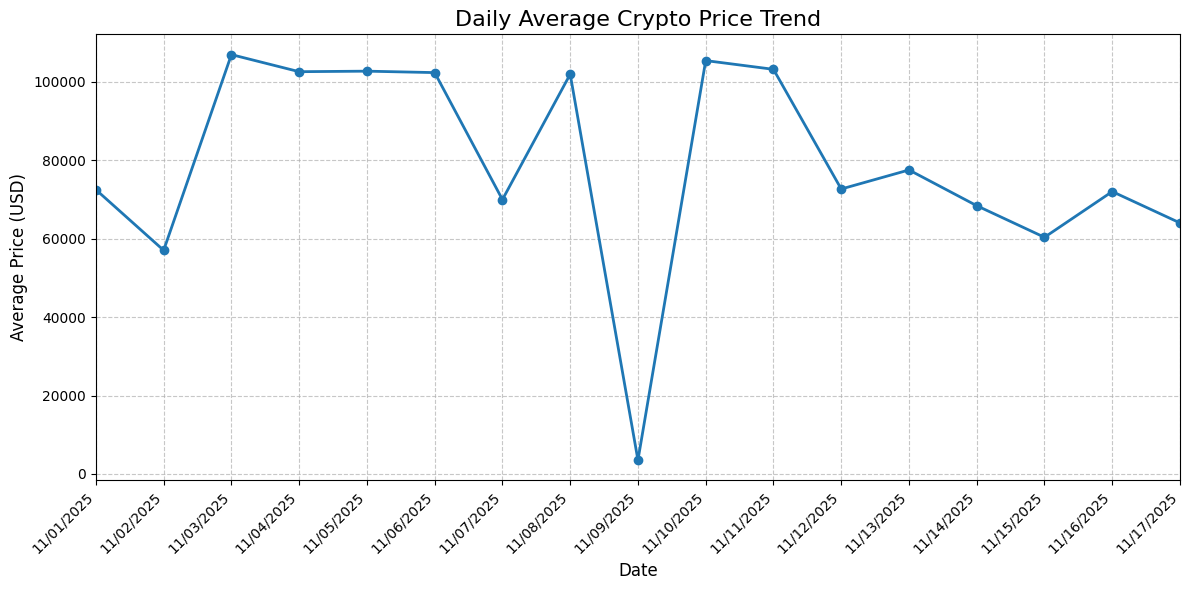

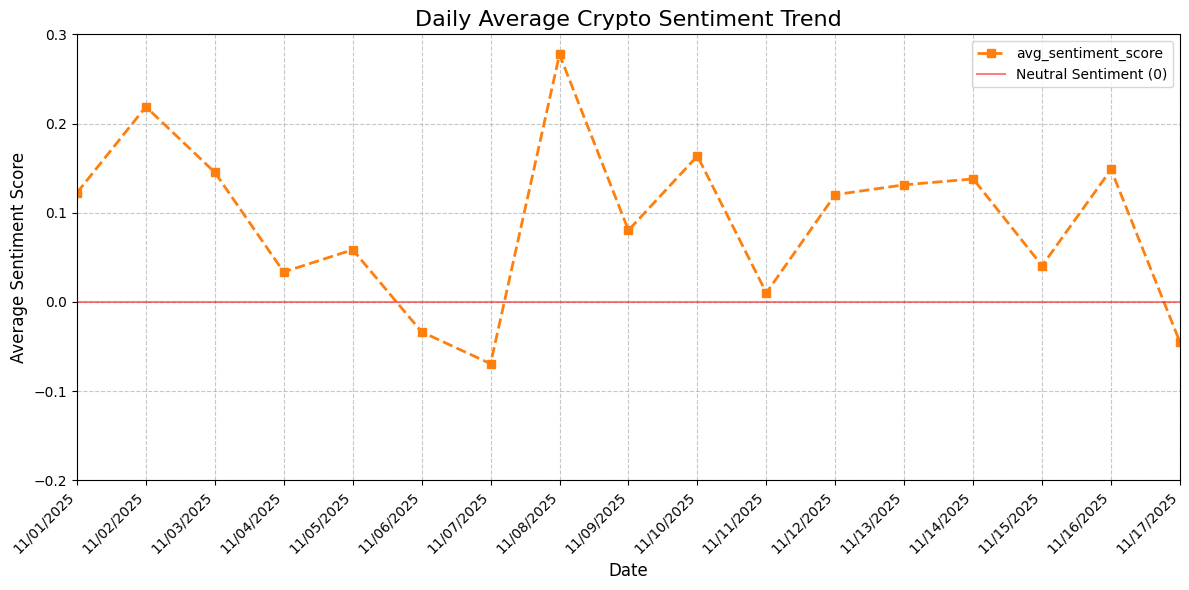

In [235]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd



# Set 'date' as the index for time-series plotting
df_daily_mean = df_daily_mean.set_index('date')

# ----------------------------------------------------------------------
# 1. Daily Average Price Trend Plot
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 6))

# Plot the price trend
df_daily_mean['avg_price'].plot(
    kind='line',
    marker='o',
    color='tab:blue',
    linewidth=2
)

plt.title("Daily Average Crypto Price Trend", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Format X-axis to show dates cleanly
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 2. Daily Average Sentiment Trend Plot
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 6))

# Plot the sentiment trend
df_daily_mean['avg_sentiment_score'].plot(
    kind='line',
    marker='s',
    color='tab:orange',
    linestyle='--',
    linewidth=2
)

plt.axhline(y=0, color='r', linestyle='-', alpha=0.5, label='Neutral Sentiment (0)') # Add neutral line
plt.title("Daily Average Crypto Sentiment Trend", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.ylim(-0.2, 0.3) # Set a fixed Y-limit for better comparison
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Format X-axis to show dates cleanly
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Another way to implement, time series analysis using sentiment_score.

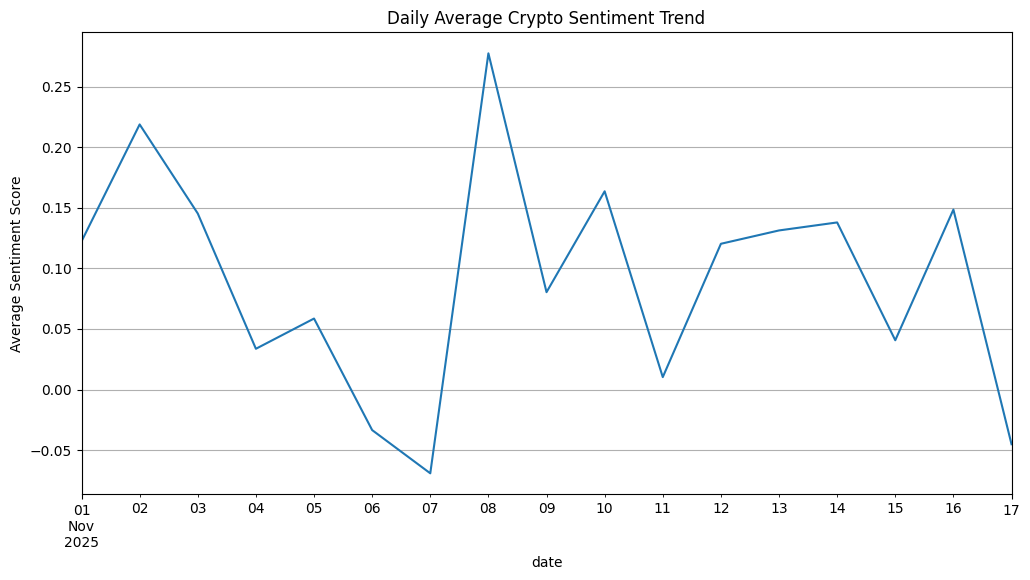

In [236]:
#time series analysis

import matplotlib.pyplot as plt

#convert pyspark dataframe to pandas dataframe
df_pandas = df_reddit_filtered.toPandas()

# 1. Overall Sentiment Trend
df_daily_sentiment = df_pandas.set_index('date').resample('D')['sentiment_score_imputed'].mean()

plt.figure(figsize=(12, 6))
df_daily_sentiment.plot(title="Daily Average Crypto Sentiment Trend")
plt.ylabel("Average Sentiment Score")
plt.grid(True)
plt.show()

Let's find out how correlation coefficient affect the pricing data and sentiment score data. It seems like correlation coefficient is postive.

If we've positive correlaltion that means price and sentiment score goes into same direction
If we've negative correelation that means price and sentiment score goes into opposite direction.
Both are type of strong relation.

If we've a 0 correlation that means we've a weak relation between two fields.

In [237]:
df_pandas.head()

,date,cryptocurrency,user_id,type,title,review,sentiment_score,sentiment_score_imputed,sentiment_label,price
0,2025-11-14 12:00:00,BTC,Silver-Maximum9190,post,"Strategy moved 58,915 BTC ($5.77B) to new wall...",missing,-0.4215,-0.421500,Negative,96787.414062
1,2025-11-14 12:00:00,BTC,TheFish77,comment,"Strategy moved 58,915 BTC ($5.77B) to new wall...",Classic vomiting frog pattern setup,0.0000,0.000000,Neutral,96787.414062
2,2025-11-14 12:00:00,BTC,Coquito3000,comment,"Strategy moved 58,915 BTC ($5.77B) to new wall...",there s blood everywhere.,0.0000,0.000000,Neutral,96787.414062
3,2025-11-14 12:00:00,BTC,CyberWeaponX,comment,"Strategy moved 58,915 BTC ($5.77B) to new wall...",Finally a pattern that makes sense. Alongside ...,0.0000,0.000000,Neutral,96787.414062
4,2025-11-14 12:00:00,BTC,tobypassquarant,comment,"Strategy moved 58,915 BTC ($5.77B) to new wall...",Red puke?,NaN,0.365246,Positive,96787.414062


In [238]:
#correlation coefficient with mean

# Calculate the Pearson correlation coefficient between the two columns
correlation_coefficient = df_daily_mean['avg_price'].corr(df_daily_mean['avg_sentiment_score'])

print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.0451327847486831


I'm performing  same mean for bitcoin

In [239]:
# --- 1. PySpark Aggregation for BTC Only ---
TARGET_CRYPTO = 'BTC' # Targeting Bitcoin
# Filter for BTC, then group by date and aggregate
df_daily_mean_BTC_spark = df_reddit_filtered\
  .filter(F.col("cryptocurrency") == TARGET_CRYPTO)\
    .withColumn(
      'date',
        F.date_trunc('day', F.col('date')) # Truncate 4h interval timestamps to the day
        ).groupBy("date").agg(
            F.mean("sentiment_score_imputed").alias("avg_sentiment_score"),
            F.mean("price").alias("avg_price")
        ).orderBy("date") \
        .withColumn("cryptocurrency", F.lit(TARGET_CRYPTO)) # Add the currency column back

    # Convert the small aggregated result to a local Pandas DataFrame for plotting
df_daily_mean_BTC = df_daily_mean_BTC_spark.toPandas()




In [240]:
df_daily_mean_BTC.head()

,date,avg_sentiment_score,avg_price,cryptocurrency
0,2025-11-01,0.115334,110224.515625,BTC
1,2025-11-02,0.257829,110172.585938,BTC
2,2025-11-03,0.145296,106937.721354,BTC
3,2025-11-04,0.033623,102581.774335,BTC
4,2025-11-05,0.058571,102716.296875,BTC


In [241]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier # or RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming 'X' contains your features (including sentiment score)
# and 'y' contains your target variable (e.g., next day's price movement: 1 for up, -1 for down)

# Example placeholder for data loading and processing (replace with your actual data)
# data = pd.read_csv('your_crypto_data.csv')
X = df_daily_mean_BTC[['avg_sentiment_score']]
y = np.where(df_daily_mean_BTC['avg_price'].shift(-1) > df_daily_mean_BTC['avg_price'], 1, -1)

# Split data (using a time-series split for financial data is often better than random split)
# Example time-series split
split_index = int(len(X) * 0.75)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42) # Adjust n_estimators and other hyperparameters
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

          -1       0.75      1.00      0.86         3
           1       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We got 0.75 accuracy for bitcoin in random forrest. Now let's do LSTM and SVM and we'll compare accuracy score

In [242]:
    pip install tensorflow

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Models Trained Successfully

CLASSIFICATION METRICS: DIRECTIONAL ACCURACY

--- LSTM Classification Report (Directional Accuracy) ---
Accuracy:  0.3333
Precision: 0.3333
Recall:    1.0000

Detailed Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3


--- SVM Classification Report (Directional Accuracy) ---
Accuracy:  0.3333
Precision: 0.3333
Recall:    1.0000

Detailed Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



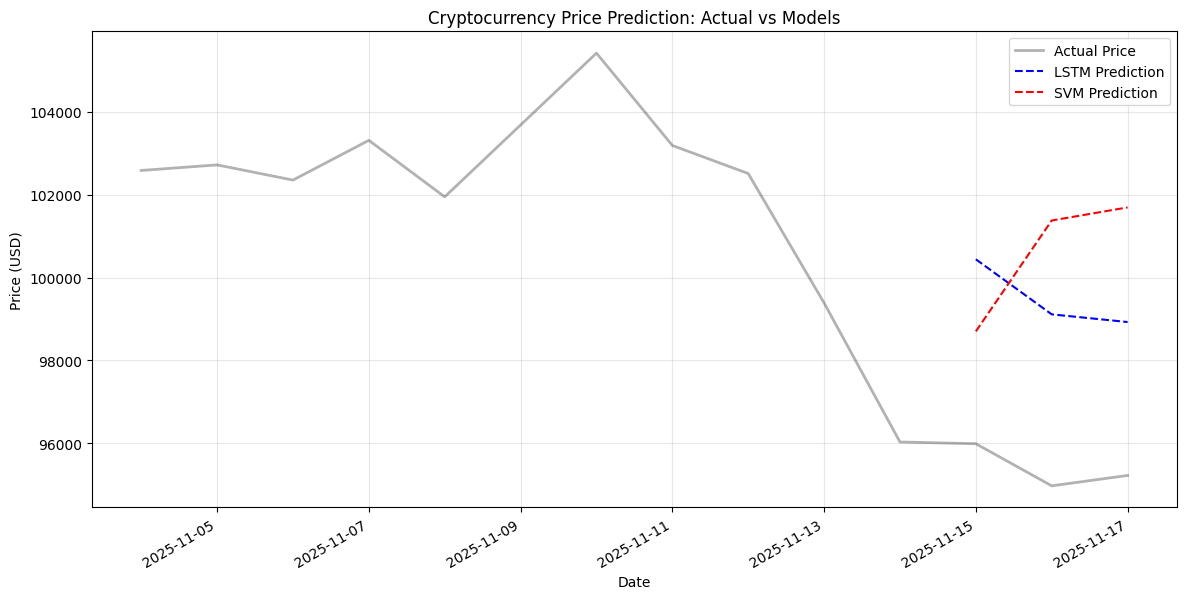

In [243]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



# Convert Spark DataFrame to Pandas DataFrame
# This brings data to the driver node
pdf = df_daily_mean_BTC_spark.select("avg_price", "avg_sentiment_score").toPandas()

# --- From here, the code is identical to your original workflow ---
data = pdf.values
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
#scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

# Create Sequences
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X, y = create_dataset(scaled_data, look_back)

# Split Train/Test
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(look_back, 2)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.fit(X_train, y_train, epochs=100, verbose=0)

#Generate predictions
# --- 1. Generate Predictions ---
# LSTM Prediction
train_predict_lstm = model_lstm.predict(X_train, verbose=0)
test_predict_lstm = model_lstm.predict(X_test, verbose=0)



# SVM
X_train_svm = X_train.reshape(X_train.shape[0], -1)
X_test_svm = X_test.reshape(X_test.shape[0], -1)
model_svm = SVR(kernel='rbf')
model_svm.fit(X_train_svm, y_train)
test_predict_svm = model_svm.predict(X_test_svm)
train_predict_svm = model_svm.predict(X_train_svm)
print("Models Trained Successfully")


# --- 2. Inverse Transform (Un-scale) ---
# The scaler expects 2 features (Price, Sentiment), but our predictions are just Price (1 feature).
# We create a helper function to pad the prediction with a dummy column to satisfy the scaler.

def inverse_transform_price(pred_array, scaler):
    # Create a dummy array with the same shape as the original input (samples, 2)
    dummy = np.zeros((len(pred_array), 2))
    # Place predictions in the first column (Price)
    dummy[:, 0] = pred_array.flatten()
    # Inverse transform and return only the price column
    return scaler.inverse_transform(dummy)[:, 0]

# Apply the function
y_train_real = inverse_transform_price(y_train, scaler)
y_test_real = inverse_transform_price(y_test, scaler)

lstm_train_real = inverse_transform_price(train_predict_lstm, scaler)
lstm_test_real = inverse_transform_price(test_predict_lstm, scaler)

svm_train_real = inverse_transform_price(train_predict_svm, scaler)
svm_test_real = inverse_transform_price(test_predict_svm, scaler)

# ==============================================================================
# --- 3. CLASSIFICATION METRICS (DIRECTIONAL ACCURACY) ---
# ==============================================================================
print("\n" + "="*50)
print("CLASSIFICATION METRICS: DIRECTIONAL ACCURACY")
print("="*50)

# 1. Get the price just before the target (Previous Price)
# X_test[:, -1, 0] gets the price feature (index 0) from the last time step (index -1)
prev_prices_scaled = X_test[:, -1, 0]
prev_prices_real = inverse_transform_price(prev_prices_scaled, scaler)

# 2. Construct Binary Classes (1 = Price UP, 0 = Price DOWN/Same)
# Actual Movement: Did the price go up relative to the previous day?
actual_direction = (y_test_real > prev_prices_real).astype(int)

# Predicted Movement (LSTM): Did the prediction suggest the price went up?
lstm_direction = (lstm_test_real > prev_prices_real).astype(int)

# Predicted Movement (SVM): Did the prediction suggest the price went up?
svm_direction = (svm_test_real > prev_prices_real).astype(int)

# 3. Calculate and Print Metrics for LSTM
print("\n--- LSTM Classification Report (Directional Accuracy) ---")
print(f"Accuracy:  {accuracy_score(actual_direction, lstm_direction):.4f}")
print(f"Precision: {precision_score(actual_direction, lstm_direction, zero_division=0):.4f}")
print(f"Recall:    {recall_score(actual_direction, lstm_direction, zero_division=0):.4f}")
print("\nDetailed Report:\n", classification_report(actual_direction, lstm_direction, zero_division=0))

# 4. Calculate and Print Metrics for SVM
print("\n--- SVM Classification Report (Directional Accuracy) ---")
print(f"Accuracy:  {accuracy_score(actual_direction, svm_direction):.4f}")
print(f"Precision: {precision_score(actual_direction, svm_direction, zero_division=0):.4f}")
print(f"Recall:    {recall_score(actual_direction, svm_direction, zero_division=0):.4f}")
print("\nDetailed Report:\n", classification_report(actual_direction, svm_direction, zero_division=0))

# Update this line in your existing code to include 'date'
pdf = df_daily_mean_BTC_spark.select("date", "avg_price", "avg_sentiment_score").toPandas()

##--- 3. Align Dates ---
# We need to match the data points to their original timestamps
# The first 'look_back' rows were consumed to create the first sequence
timestamps = pdf['date'].values[look_back:]

# Split timestamps into train and test to match the X splits
train_dates = timestamps[:train_size]
test_dates = timestamps[train_size:]

# --- 4. Plotting ---
plt.figure(figsize=(14, 7))

# Plot Actual Prices (Ground Truth)
# We concatenate train and test to show the full continuous line
plt.plot(timestamps, np.concatenate([y_train_real, y_test_real]),
         label='Actual Price', color='black', linewidth=2, alpha=0.3)

# Plot LSTM Predictions (Test Set)
plt.plot(test_dates, lstm_test_real,
         label='LSTM Prediction', color='blue', linestyle='--', linewidth=1.5)

# Plot SVM Predictions (Test Set)
plt.plot(test_dates, svm_test_real,
         label='SVM Prediction', color='red', linestyle='--', linewidth=1.5)

plt.title('Cryptocurrency Price Prediction: Actual vs Models')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format date axis for better readability
plt.gcf().autofmt_xdate()

plt.show()

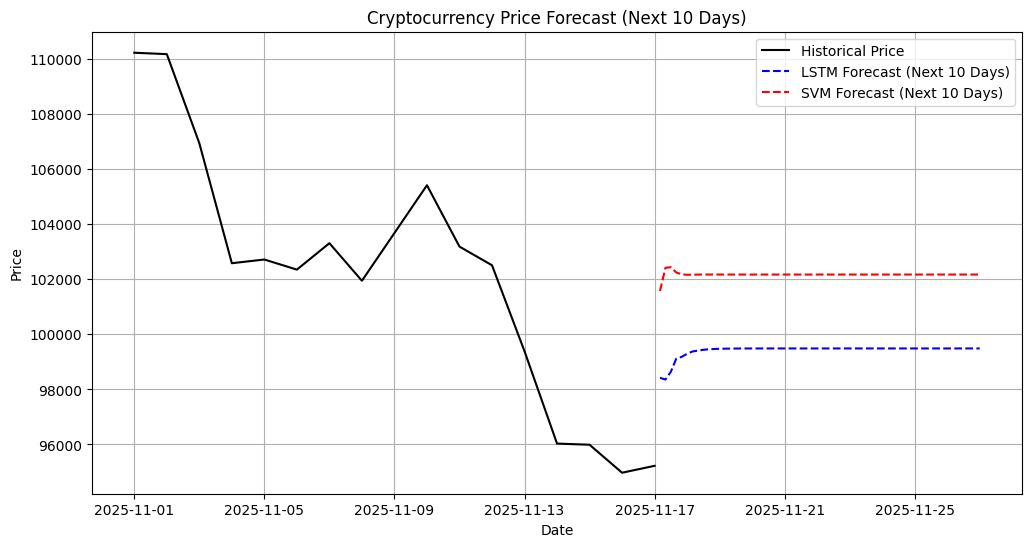

In [244]:
#forecasting for next ten days
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# --- 1. Setup Forecast Parameters ---
# 5 days * 6 intervals per day (since data is 4-hourly) = 30 steps
future_steps = 60

# Get the last sequence from your original data to start the chain
# Shape: (1, look_back, 2)
last_sequence = scaled_data[-look_back:]
current_batch = last_sequence.reshape(1, look_back, 2)

# We need to store predictions
lstm_forecast = []
svm_forecast = []

# For the simulation, we must assume future sentiment.
# We will use the last known sentiment value to remain conservative.
last_sentiment = last_sequence[-1, 1]

# --- 2. Generate LSTM Forecast ---
curr_lstm = current_batch.copy()
for i in range(future_steps):
    # Predict next price (output is scaled)
    pred_price = model_lstm.predict(curr_lstm, verbose=0)[0, 0]
    lstm_forecast.append(pred_price)

    # Create new input row: [Predicted_Price, Last_Sentiment]
    new_row = np.array([[pred_price, last_sentiment]])

    # Update batch: Drop oldest time step, add new prediction
    curr_lstm = np.append(curr_lstm[:, 1:, :], [new_row], axis=1)

# --- 3. Generate SVM Forecast ---
# SVM needs 2D input (1, look_back * 2)
curr_svm = current_batch.copy()
for i in range(future_steps):
    # Flatten for SVM
    svm_input = curr_svm.reshape(1, -1)

    pred_price = model_svm.predict(svm_input)[0]
    svm_forecast.append(pred_price)

    new_row = np.array([[pred_price, last_sentiment]])

    # Update batch for next iteration (maintain 3D shape for easy manipulation)
    curr_svm = np.append(curr_svm[:, 1:, :], [new_row], axis=1)

# --- 4. Inverse Scale Predictions ---
# Scaler expects 2 columns (Price, Sentiment), so we pad with zeros to inverse transform
def inverse_scale_forecast(forecast_list, scaler):
    dummy_array = np.zeros((len(forecast_list), 2))
    dummy_array[:, 0] = forecast_list # Fill price column
    return scaler.inverse_transform(dummy_array)[:, 0]

lstm_forecast_real = inverse_scale_forecast(lstm_forecast, scaler)
svm_forecast_real = inverse_scale_forecast(svm_forecast, scaler)

# --- 5. Create Future Dates ---
last_date = pd.to_datetime(pdf['date'].max()) # Assuming 'timestamp' is in your pdf
future_dates = [last_date + timedelta(hours=4 * (i+1)) for i in range(future_steps)]

# --- 6. Plotting ---
plt.figure(figsize=(12, 6))

# Plot last 50 actual data points for context
plt.plot(pdf['date'].tail(50), pdf['avg_price'].tail(50), label='Historical Price', color='black')

# Plot Forecasts
plt.plot(future_dates, lstm_forecast_real, label='LSTM Forecast (Next 10 Days)', color='blue', linestyle='--')
plt.plot(future_dates, svm_forecast_real, label='SVM Forecast (Next 10 Days)', color='red', linestyle='--')

plt.title('Cryptocurrency Price Forecast (Next 10 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [245]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df_numerical = df_daily_mean_BTC.select_dtypes(include=['float64', 'int64'])
X_std = StandardScaler().fit_transform(df_numerical)

# Now, use the numerical data for scaling and clustering
X_std = StandardScaler().fit_transform(df_numerical)
km = KMeans(n_clusters=2, max_iter=50, random_state=42) # Added random_state for reproducibility
km.fit(X_std)

centroids = km.cluster_centers_



In [253]:
df_daily_mean_BTC = df_daily_mean_BTC_spark.toPandas()

df_daily_mean_BTC.columns

Index(['date', 'avg_sentiment_score', 'avg_price', 'cryptocurrency'], dtype='object')

I'm performing timeseries analysis for bitcoin

set date index


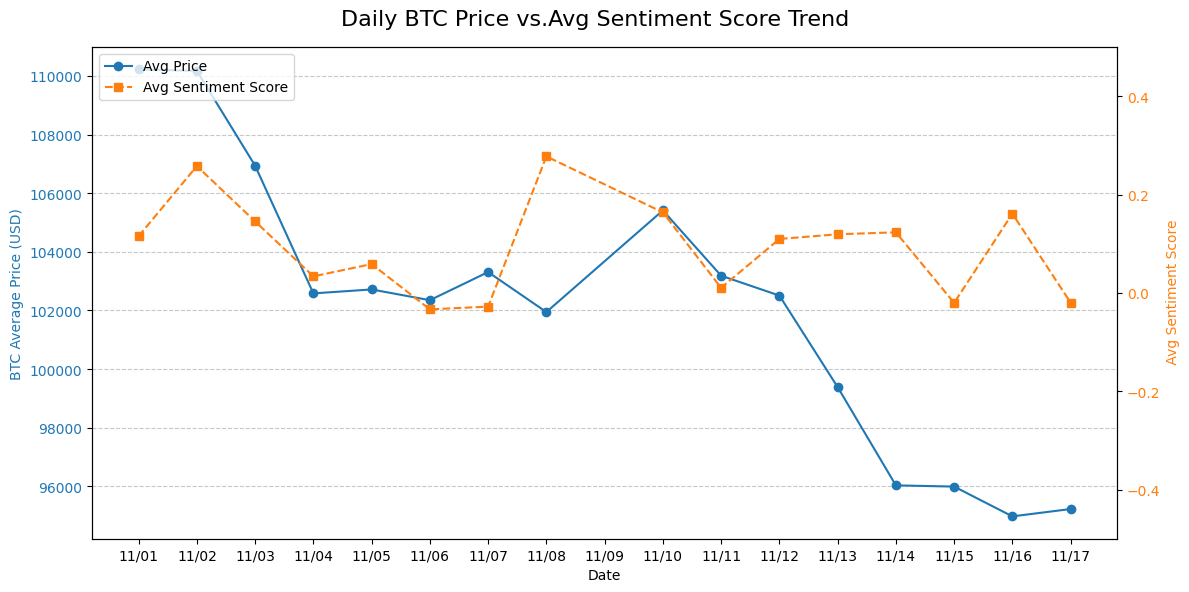

In [254]:
# --- 2. Pandas Plotting (Dual-Axis) ---
if not df_daily_mean_BTC.empty:
    df_daily_mean_BTC = df_daily_mean_BTC.set_index('date')

    print("set date index")

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot 1: Average Price (Primary Y-axis, left)
    color_price = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{TARGET_CRYPTO} Average Price (USD)', color=color_price)
    line1 = ax1.plot(df_daily_mean_BTC.index, df_daily_mean_BTC['avg_price'], color=color_price, marker='o', linestyle='-', label='Avg Price')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Average Sentiment Score (Secondary Y-axis, right)
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color_sentiment = 'tab:orange'
    ax2.set_ylabel(' Avg Sentiment Score', color=color_sentiment)
    line2 = ax2.plot(df_daily_mean_BTC.index, df_daily_mean_BTC['avg_sentiment_score'], color=color_sentiment, marker='s', linestyle='--', label='Avg Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color_sentiment)
    ax2.set_ylim(-0.5, 0.5) # Set a fixed y-limit for sentiment score for readability

    # Add a combined title and legend
    fig.suptitle(f'Daily {TARGET_CRYPTO} Price vs.Avg Sentiment Score Trend', fontsize=16)

    # Combine legends from both axes
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Format X-axis for better date display
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xticks(rotation=45, ha='right')

    fig.tight_layout()
    plt.show()
else:
    print(f"❌ Cannot plot: DataFrame for {TARGET_CRYPTO} is empty after aggregation.")

In [249]:
df_daily_mean_BTC.head()

,avg_sentiment_score,avg_price,cryptocurrency
date,,,
2025-11-01,0.115334,110224.515625,BTC
2025-11-02,0.257829,110172.585938,BTC
2025-11-03,0.145296,106937.721354,BTC
2025-11-04,0.033623,102581.774335,BTC
2025-11-05,0.058571,102716.296875,BTC


In [255]:
#correlation coefficient with mean for BTC

# Calculate the Pearson correlation coefficient between the two columns
correlation_coefficient = df_daily_mean_BTC['avg_price'].corr(df_daily_mean_BTC['avg_sentiment_score'])

print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.33761614457380124


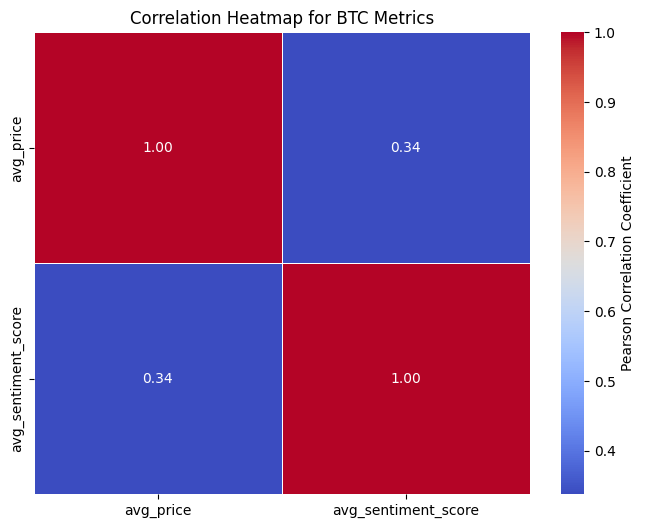

In [256]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select the relevant numerical columns from your DataFrame
# Include 'avg_price', 'avg_sentiment_score', and any other numerical columns

numerical_features = [
    'avg_price',
    'avg_sentiment_score',

]

# Create the correlation matrix
correlation_matrix = df_daily_mean_BTC[numerical_features].corr(method='pearson')

# 2. Plot the Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show the correlation values on the map
    cmap='coolwarm',     # Use a clear color scheme
    fmt=".2f",           # Format the numbers to two decimal places
    linewidths=.5,       # Add lines between cells for clarity
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)

plt.title('Correlation Heatmap for BTC Metrics')
plt.show()

In [257]:
df_daily_mean_BTC.head(n=3)

,avg_sentiment_score,avg_price,cryptocurrency
date,,,
2025-11-01,0.115334,110224.515625,BTC
2025-11-02,0.257829,110172.585938,BTC
2025-11-03,0.145296,106937.721354,BTC


In [258]:
#Daily Price Difference for BTC

if 'date' in df_daily_mean_BTC.columns:
      df_daily_mean_BTC['date'] = pd.to_datetime(df_daily_mean_BTC['date'])
      df_daily_mean_BTC = df_daily_mean_BTC.set_index('date').sort_index()
else:
        # If 'date' is already the index, ensure the index type is correct
      if not pd.api.types.is_datetime64_any_dtype(df_daily_mean_BTC.index):
          df_daily_mean_BTC.index = pd.to_datetime(df_daily_mean_BTC.index)
          df_daily_mean_BTC = df_daily_mean_BTC.sort_index()

# --- NEW CALCULATION: Daily Price Difference ---
    # 1. Calculate the price difference by subtracting the previous day's price.
df_daily_mean_BTC['daily_price_difference'] = (
        df_daily_mean_BTC['avg_price'] - df_daily_mean_BTC['avg_price'].shift(1)
    )

df_daily_mean_reset = df_daily_mean_BTC.reset_index()
print("\n--- DataFrame after Resetting Index (All columns are selectable) ---")
# FIX: Print the head directly to show 'date' as a column, avoiding the KeyError
print(df_daily_mean_reset.head().to_markdown(numalign="left", stralign="left", floatfmt=",.2f"))

   # The first day's difference will be NaN, which is correct.
print(f"\n--- Daily Price Difference for BTC ---")
print(df_daily_mean_BTC.head(n=30))








--- DataFrame after Resetting Index (All columns are selectable) ---
|    | date                | avg_sentiment_score   | avg_price   | cryptocurrency   | daily_price_difference   |
|:---|:--------------------|:----------------------|:------------|:-----------------|:-------------------------|
| 0  | 2025-11-01 00:00:00 | 0.12                  | 110,224.52  | BTC              | nan                      |
| 1  | 2025-11-02 00:00:00 | 0.26                  | 110,172.59  | BTC              | -51.93                   |
| 2  | 2025-11-03 00:00:00 | 0.15                  | 106,937.72  | BTC              | -3,234.86                |
| 3  | 2025-11-04 00:00:00 | 0.03                  | 102,581.77  | BTC              | -4,355.95                |
| 4  | 2025-11-05 00:00:00 | 0.06                  | 102,716.30  | BTC              | 134.52                   |

--- Daily Price Difference for BTC ---
            avg_sentiment_score      avg_price cryptocurrency  \
date                              

In [259]:
# --- 1. PySpark Aggregation for BTC Only ---
TARGET_CRYPTO = 'ETH' # Targeting Bitcoin
# Filter for BTC, then group by date and aggregate
df_daily_mean_ETH_spark = df_reddit_filtered\
  .filter(F.col("cryptocurrency") == TARGET_CRYPTO)\
    .withColumn(
      'date',
        F.date_trunc('day', F.col('date')) # Truncate 4h interval timestamps to the day
        ).groupBy("date").agg(
            F.mean("sentiment_score").alias("avg_sentiment_score"),
            F.mean("price").alias("avg_price")
        ).orderBy("date") \
        .withColumn("cryptocurrency", F.lit(TARGET_CRYPTO)) # Add the currency column back

    # Convert the small aggregated result to a local Pandas DataFrame for plotting
df_daily_mean_ETH = df_daily_mean_ETH_spark.toPandas()


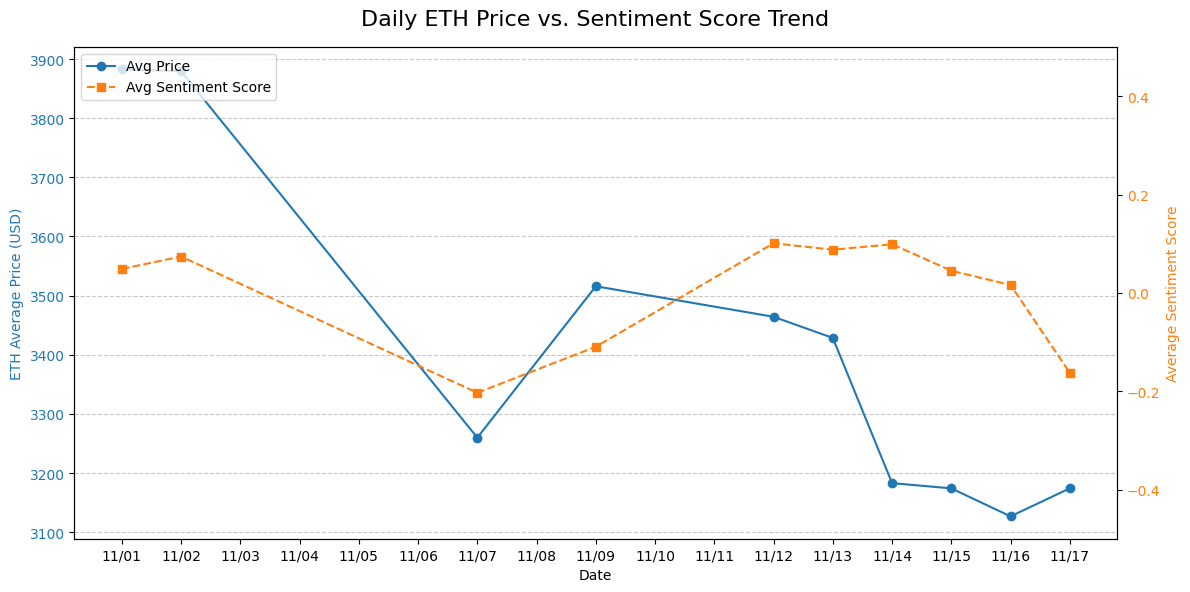

In [260]:
# --- 2. Pandas Plotting (Dual-Axis) ---
if not df_daily_mean_ETH.empty:
    df_daily_mean_ETH = df_daily_mean_ETH.set_index('date')

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot 1: Average Price (Primary Y-axis, left)
    color_price = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'ETH Average Price (USD)', color=color_price)
    line1 = ax1.plot(df_daily_mean_ETH.index, df_daily_mean_ETH['avg_price'], color=color_price, marker='o', linestyle='-', label='Avg Price')
    ax1.tick_params(axis='y', labelcolor=color_price)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Plot 2: Average Sentiment Score (Secondary Y-axis, right)
    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color_sentiment = 'tab:orange'
    ax2.set_ylabel('Average Sentiment Score', color=color_sentiment)
    line2 = ax2.plot(df_daily_mean_ETH.index, df_daily_mean_ETH['avg_sentiment_score'], color=color_sentiment, marker='s', linestyle='--', label='Avg Sentiment Score')
    ax2.tick_params(axis='y', labelcolor=color_sentiment)
    ax2.set_ylim(-0.5, 0.5) # Set a fixed y-limit for sentiment score for readability

    # Add a combined title and legend
    fig.suptitle(f'Daily ETH Price vs. Sentiment Score Trend', fontsize=16)

    # Combine legends from both axes
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Format X-axis for better date display
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xticks(rotation=45, ha='right')

    fig.tight_layout()
    plt.show()
else:
    print(f"❌ Cannot plot: DataFrame for {TARGET_CRYPTO} is empty after aggregation.")

In [261]:
#Daily Price Difference for ETH

if 'date' in df_daily_mean_ETH.columns:
      df_daily_mean_ETH['date'] = pd.to_datetime(df_daily_mean_ETH['date'])
      df_daily_mean_ETH = df_daily_mean_ETH.set_index('date').sort_index()
else:
        # If 'date' is already the index, ensure the index type is correct
      if not pd.api.types.is_datetime64_any_dtype(df_daily_mean_ETH.index):
          df_daily_mean_ETH.index = pd.to_datetime(df_daily_mean_ETH.index)
          df_daily_mean_ETH = df_daily_mean_ETH.sort_index()

# --- NEW CALCULATION: Daily Price Difference ---
    # 1. Calculate the price difference by subtracting the previous day's price.
df_daily_mean_ETH['daily_price_difference'] = (
        df_daily_mean_ETH['avg_price'] - df_daily_mean_ETH['avg_price'].shift(1)
    )

df_daily_mean_reset = df_daily_mean_ETH.reset_index()
print("\n--- DataFrame after Resetting Index (All columns are selectable) ---")
# FIX: Print the head directly to show 'date' as a column, avoiding the KeyError
print(df_daily_mean_reset.head().to_markdown(numalign="left", stralign="left", floatfmt=",.2f"))

   # The first day's difference will be NaN, which is correct.
print(f"\n--- Daily Price Difference for ETH ---")
print(df_daily_mean_ETH.head(n=30))








--- DataFrame after Resetting Index (All columns are selectable) ---
|    | date                | avg_sentiment_score   | avg_price   | cryptocurrency   | daily_price_difference   |
|:---|:--------------------|:----------------------|:------------|:-----------------|:-------------------------|
| 0  | 2025-11-01 00:00:00 | 0.05                  | 3,882.52    | ETH              | nan                      |
| 1  | 2025-11-02 00:00:00 | 0.07                  | 3,879.49    | ETH              | -3.03                    |
| 2  | 2025-11-07 00:00:00 | -0.20                 | 3,259.85    | ETH              | -619.63                  |
| 3  | 2025-11-09 00:00:00 | -0.11                 | 3,515.83    | ETH              | 255.97                   |
| 4  | 2025-11-12 00:00:00 | 0.10                  | 3,464.22    | ETH              | -51.60                   |

--- Daily Price Difference for ETH ---
            avg_sentiment_score    avg_price cryptocurrency  \
date                                

In [262]:
#correlation coefficient with mean for ETH

# Calculate the Pearson correlation coefficient between the two columns
correlation_coefficient_ETH = df_daily_mean_ETH['avg_price'].corr(df_daily_mean_ETH['avg_sentiment_score'])

print(f"Correlation Coefficient: {correlation_coefficient_ETH}")

Correlation Coefficient: 0.28947130380643155


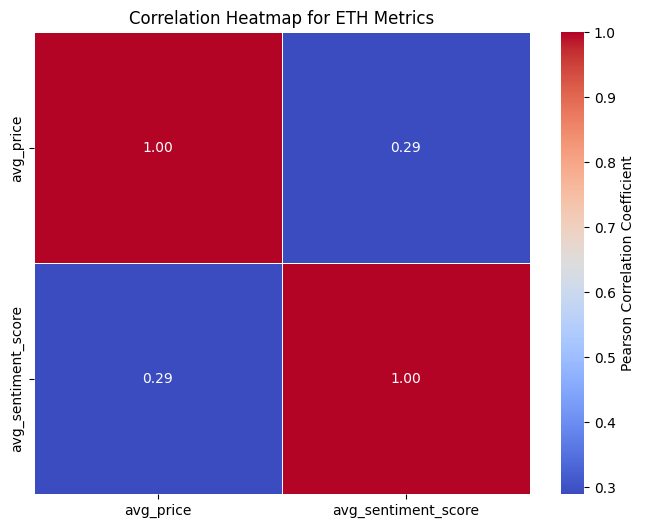

In [263]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select the relevant numerical columns from your DataFrame
# Include 'avg_price', 'avg_sentiment_score', and any other numerical columns

numerical_features = [
    'avg_price',
    'avg_sentiment_score',

]

# Create the correlation matrix
correlation_matrix = df_daily_mean_ETH[numerical_features].corr(method='pearson')

# 2. Plot the Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show the correlation values on the map
    cmap='coolwarm',     # Use a clear color scheme
    fmt=".2f",           # Format the numbers to two decimal places
    linewidths=.5,       # Add lines between cells for clarity
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)

plt.title('Correlation Heatmap for ETH Metrics')
plt.show()

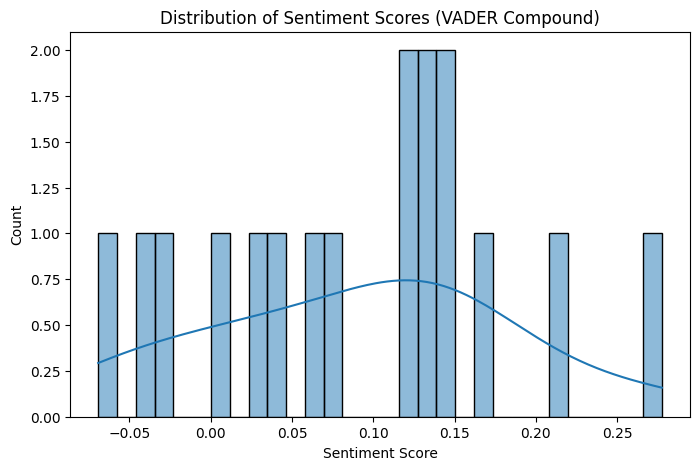

In [264]:
#distribution analysis: Visualize the distribution
#of the core metric, sentiment_score, to see if the overall mood is neutral, positive, or negative.

import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_daily_mean['avg_sentiment_score'], bins=30, kde=True)
plt.title("Distribution of Sentiment Scores (VADER Compound)")
plt.xlabel("Sentiment Score")
plt.show()

/tmp/ipython-input-3127082703.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'cryptocurrency', y='unique_user_count',data=df_pandas_count, palette='viridis')


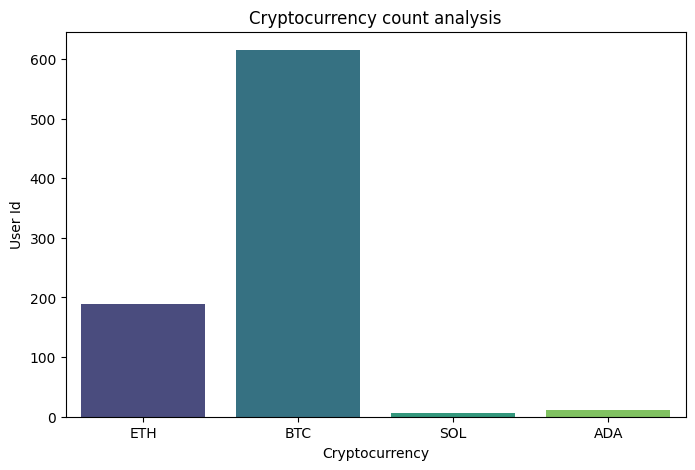

In [265]:

import seaborn as sns

from pyspark.sql import functions as F

# 1. Group by cryptocurrency and count the number of records (posts/comments).
#df_count_spark = df_filtered_and_joined.groupBy("cryptocurrency").count().orderBy(F.desc("count"))

from pyspark.sql.functions import col, countDistinct
df_count_spark =  df_reddit_filtered.groupBy("cryptocurrency").agg(countDistinct("user_id").alias("unique_user_count"))

# 2. Convert the small aggregated result to a Pandas DataFrame for plotting.
df_pandas_count = df_count_spark.toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(x= 'cryptocurrency', y='unique_user_count',data=df_pandas_count, palette='viridis')
plt.title("Cryptocurrency count analysis")
plt.xlabel("Cryptocurrency")
plt.ylabel("User Id")
plt.show()

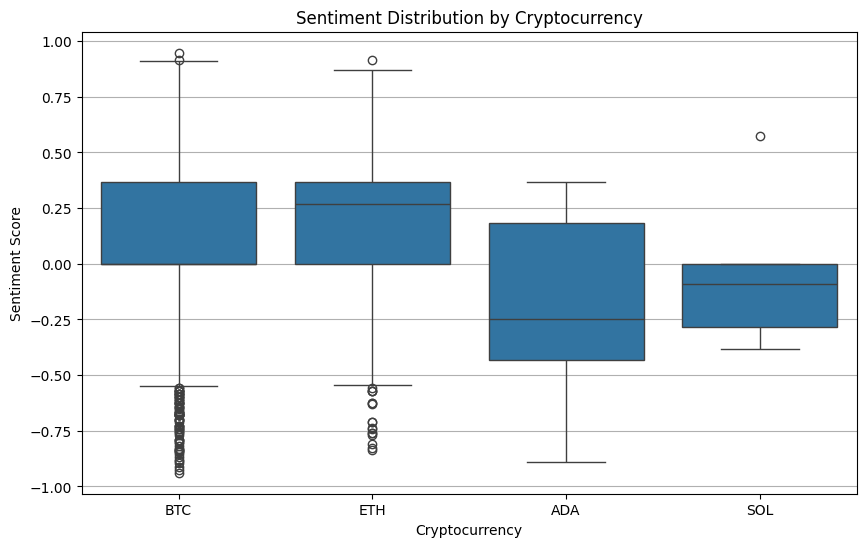


--- Mean Sentiment by Coin ---
cryptocurrency
ETH    0.036471
BTC   -0.009225
SOL   -0.051000
ADA   -0.374812
Name: sentiment_score, dtype: float64


In [266]:
#Distribution analysis

plt.figure(figsize=(10, 6))
# Create a box plot to compare the sentiment distribution across different cryptocurrencies
sns.boxplot(x='cryptocurrency', y='sentiment_score_imputed', data=df_pandas)
plt.title("Sentiment Distribution by Cryptocurrency")
plt.xlabel("Cryptocurrency")
plt.ylabel("Sentiment Score")
plt.grid(axis='y')
plt.show()

# Calculate the mean sentiment for each coin
mean_sentiment_by_coin = df_pandas.groupby('cryptocurrency')['sentiment_score'].mean().sort_values(ascending=False)
print("\n--- Mean Sentiment by Coin ---")
print(mean_sentiment_by_coin)

In [267]:
df_pandas.columns

Index(['date', 'cryptocurrency', 'user_id', 'type', 'title', 'review',
       'sentiment_score', 'sentiment_score_imputed', 'sentiment_label',
       'price'],
      dtype='object')

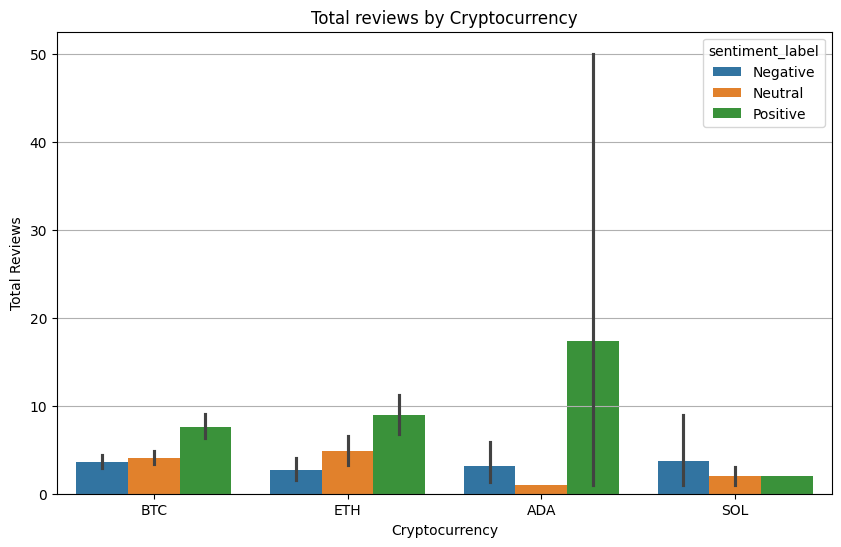


--- Mean Sentiment by Coin ---
cryptocurrency
BTC    100244.234975
ETH      3333.230116
SOL       153.247833
ADA         0.492878
Name: price, dtype: float64


In [268]:
#Distribution analysis

import seaborn as sns
df_pandas['total_reviews_per_userid'] = df_pandas.groupby('user_id')['user_id'].transform('count')

plt.figure(figsize=(10, 6))
# Create a box plot to compare the sentiment distribution across different cryptocurrencies
sns.barplot(x='cryptocurrency', y='total_reviews_per_userid', data=df_pandas,hue='sentiment_label',)
plt.title("Total reviews by Cryptocurrency")
plt.xlabel("Cryptocurrency")
plt.ylabel("Total Reviews")
plt.grid(axis='y')
plt.show()

# Calculate the mean sentiment for each coin
mean_price_by_coin = df_pandas.groupby('cryptocurrency')['price'].mean().sort_values(ascending=False)
print("\n--- Mean Sentiment by Coin ---")
print(mean_price_by_coin)

In [ ]:
#remove rows which has a garbage timestamp or null timestamp --done

In [ ]:
#create a bar chart for cryptocurrency to demonstrate number of users who post and comment for cryptocurrency -- done

In [ ]:
#create a column chart for number of title and revviews for cryptocurrency

In [ ]:
#create a bar chart to count sentiment score for cryptocurrency -- donne

In [ ]:
#polarity score check

In [ ]:
#time series analysis -- timeestamp as id-- with pricing and sentiment data --done

In [ ]:
#Corelation coefficient --done

In [ ]:
#https://www.kaggle.com/code/suzanaiacob/sentiment-analysis-of-the-yelp-reviews-data
#https://www.kaggle.com/code/serkanp/imdb-sentiment-analysis-data-exploration
#https://www.kaggle.com/code/ryanholbrook/exercise-binary-classification
#https://www.kaggle.com/code?searchQuery=sentiment+data+
#https://www.kaggle.com/code/benhamner/exploring-airline-twitter-sentiment-data
#https://www.kaggle.com/code/seunowo/sentiment-analysis-twitter-dataset
#https://www.kaggle.com/code/nageshsingh/stock-market-forecasting-arima
#https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#https://www.datacamp.com/tutorial/lstm-python-stock-market
#https://www.datacamp.com/tutorial/random-forests-classifier-python
#https://www.datacamp.com/tutorial/lstm-python-stock-market
#https://medium.com/@pennQuin/implementation-of-long-short-term-memory-lstm-81e35fa5ca54
#https://medium.com/@arthurfn/random-forest-and-technical-analysis-to-predict-bitcoin-price-0b3a30126901

In [ ]:
sc.stop()

In [ ]:
rf = RandomForestRegressor(n_estimators=30, max_depth=49, random_state=137, n_jobs=-1)
rf.fit(X_train, y_train)